In [1]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)


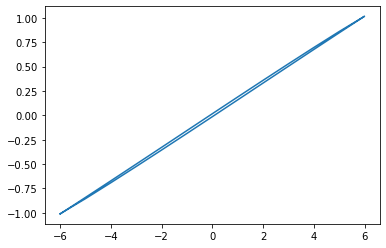

In [2]:
fname = 'D:/SLAC/hysteresis/magnet_characterization/1.26Q3.5_4034/strplt.ru1'

data = []
with open(fname,'r') as f:
    f.readline()
    for line in f:
        temp = line.rstrip().split(' ')
        d = []
        for ele in temp:
            if ele != '':
                d += [ele]
        data += [d]
data = np.asfarray(data)

# get real h, m
h = torch.tensor(data[:,1]).double()
m = torch.tensor(data[:,3]).double() * np.where(data[:,7] < 0, -1, 1)
h_train = h
m_train = m

fig, ax  = plt.subplots()
ax.plot(h_train, m_train)

In [3]:
from hysteresis.base import BaseHysteresis
from hysteresis.training import train_hysteresis
H = BaseHysteresis(
    train_h=h_train,
    train_m=m_train,
    mesh_scale=0.5,
    polynomial_degree=1
)
for name, param in H.named_parameters():
    print(f'{name}:{param}')

raw_hysterion_density:Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 

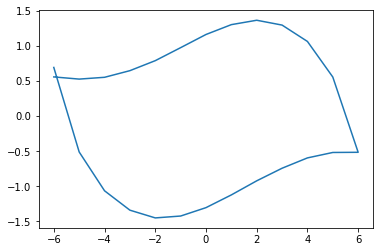

In [4]:
l = train_hysteresis(H, 5000, lr =0.01)

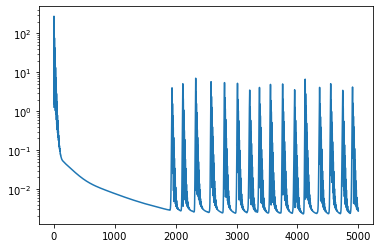

In [5]:
fig, ax = plt.subplots()
ax.semilogy(l)

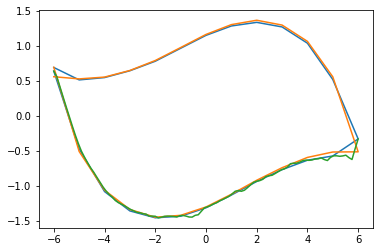

In [6]:
pred_m = H(h_train)
#ph, pm = H.transformer.transform(h_train, pred_m)
th, tm = H.transformer.transform(h_train, m_train)
fig, ax = plt.subplots()
ax.plot(h_train, pred_m.detach(), label='Model regression')
ax.plot(h_train, tm.detach(), label='Training data')

H.next()
future_h = torch.linspace(*H.valid_domain, 100)
future_m = H(future_h)
ax.plot(future_h, future_m.detach(), label='Model prediction')

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

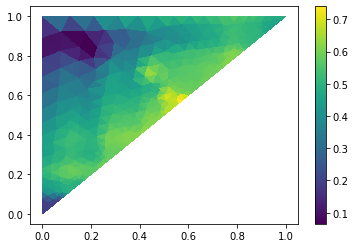

In [7]:
from hysteresis.visualization import plot_hysterion_density
plot_hysterion_density(H)

In [8]:
torch.save(H, 'q4034.pt')

